# Part 3


1) Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

Term Frequency–Inverse Document Frequency (TF-IDF) measures how relevant a word is in a specific text. It is calculated by taking the product of TF (Term Frequency) and the IDF (Inverse Document Frequency). 

The TF measures how often a word appears in a text and the IDF measures how specific a word is to a text in question. This is done by comparing the number of text parts that contain that word with the total number of different texts.

Thus, by combining these 2 metrics, the TF-IDF score highlights words that are frequent in one text but rare in the rest of the collection. A high TF-IDF means that a work is highly descriptive of a certain text, because it appears in the text many times (high TF), but not so many in the other texts (high IDF).

Therefore, we can use TF-IDF to recognize the words that are truly intrinsic and, thus, characterize, a certain genre or community. In fact, artists that have the same words with higher values of TF-IDF probably share some type of relationship (same genre or other type of connection) and, thus, are more likely to belong to the same community. 

This way, we can use TF-IDF to better undertsand the words that are more relevant per genre, and, thus, identify it. Moreover, we also use it to identify relationships between artists that are crucial when we analyse our network structure and find the communities present. 


2) Calculate and visualize TF-IDF for the genres and communities.

In [68]:
#imports

import math
from collections import Counter
from pathlib import Path
import networkx as nx
import pickle as pkl
import random
import string
from collections import Counter, defaultdict
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
def compute_tfidf(group_folder, label_type, top_n=10):
    """
    Compute TF-IDF for each group/community from *_TF.txt files.
    Prints top words in a clean, report-style format.
    """
    group_folder = Path(group_folder)
    group_tf = {}
    all_words = set()

    # --- Load TF lists ---
    for file in group_folder.glob("*_TF.txt"):
        name = file.stem  

        #  remove prefix (
        if name.lower().startswith("primary_"):
            prefix_removed = name[8:] 
        elif name.lower().startswith("random_"):
            prefix_removed = name[7:]  
        elif name.lower().startswith("louvain_"):
            prefix_removed = name[8:]

        # remove "_TF"
        prefix_removed = prefix_removed[:-3]

        # clean up spacing and capitalization
        clean_name = prefix_removed.strip().upper()

        # Store words and frequencies
        counts = Counter()
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                    word, freq = line.strip().split()
                    freq = int(freq)
                    counts[word] = freq
                    all_words.add(word)
        group_tf[clean_name] = counts

    # Compute DF 
    df = Counter()
    for word in all_words:
        df[word] = sum(1 for tf_counts in group_tf.values() if word in tf_counts)

    # Compute IDF 
    N = len(group_tf)
    idf = {word: math.log((N + 1) / (df[word] + 1)) for word in all_words}

    # Compute TF-IDF 
    group_tfidf = {}
    for group_name, tf_counts in group_tf.items():
        total_words = sum(tf_counts.values())
        tfidf = {word: (count / total_words) * idf[word] for word, count in tf_counts.items()}
        group_tfidf[group_name] = tfidf

    # Print the results
    for group_name, tfidf_dict in group_tfidf.items():
        if "louvain" in label_type.lower():
            print(f"\n=== [{label_type.upper()}] Top {top_n} TF-IDF words for community {group_name} ===")
        else:
            print(f"\n=== [{label_type.upper()}] Top {top_n} TF-IDF words for genre: {group_name} ===")
        top_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            print(f"{word:<20s} {score:>10.6f}")

    return group_tfidf, idf, df


This part is copied from part 2 to calculate the communities and genres. 

In [7]:
# Open dict with artist names and genres
with open("artist_genres.pkl", "rb") as file:
    artist_genres = pkl.load(file)
print(artist_genres)

{'disturbed (band)': ['heavy metal', 'alternative metal', 'hard rock', 'nu metal', '(early)'], 'breaking benjamin': ['hard rock', 'post-grunge', 'alternative metal', 'alternative rock'], 'mudvayne': ['alternative metal', 'nu metal', 'progressive metal', 'hard rock'], 'korn': ['nu metal', 'alternative metal'], 'deftones': ['alternative metal', 'art rock', 'shoegaze', 'nu metal', '(early)'], 'stone temple pilots': ['alternative rock', 'grunge', 'hard rock', 'alternative metal', 'psychedelic rock'], 'thousand foot krutch': ['christian rock', 'christian metal', 'heavy metal', 'hard rock', 'alternative rock', 'nu metal', 'rap metal'], 'linkin park': ['alternative rock', 'nu metal', 'rap rock', 'alternative metal', 'electronic rock', 'pop rock'], 'shinedown': ['hard rock', 'alternative metal', 'post-grunge', 'alternative rock', 'pop rock'], '10cc': ['art rock', 'art pop', 'progressive pop', 'soft rock', 'pop rock'], 'the hollies': ['rock', 'pop'], 'the beatles': ['rock', 'pop', 'beat', 'psyc

In [8]:
# Load the graph
print("Loading graph... \n")
G = nx.read_graphml("new_rock_artists.graphml")
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Use only the undirected version of the graph
G = G.to_undirected()
print(f"Converted to undirected graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Get artist names from the artist_genres dictionary
artist_names = list(artist_genres.keys())
print(f"Number of artists with genre information: {len(artist_names)}\n")

# Select only nodes with a genre attribute
G = G.subgraph(artist_names)
print(f"Subgraph with genre attribute has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

# Visualize the nodes to check
G.nodes(data=True)

Loading graph... 

Loaded graph with 484 nodes and 8052 edges

Converted to undirected graph with 484 nodes and 6537 edges

Number of artists with genre information: 343

Subgraph with genre attribute has 343 nodes and 4382 edges



NodeDataView({'disturbed (band)': {'length_of_content': 10685}, 'breaking benjamin': {'length_of_content': 15060}, 'mudvayne': {'length_of_content': 7206}, 'korn': {'length_of_content': 26668}, 'deftones': {'length_of_content': 18978}, 'stone temple pilots': {'length_of_content': 9523}, 'thousand foot krutch': {'length_of_content': 6342}, 'linkin park': {'length_of_content': 34784}, 'shinedown': {'length_of_content': 11585}, '10cc': {'length_of_content': 10464}, 'the hollies': {'length_of_content': 6061}, 'the beatles': {'length_of_content': 32613}, 'frank zappa': {'length_of_content': 31101}, 'queen (band)': {'length_of_content': 42039}, 'george harrison': {'length_of_content': 24091}, 'asia (band)': {'length_of_content': 9029}, 'duran duran': {'length_of_content': 18336}, 'peter gabriel': {'length_of_content': 18820}, 'the clash': {'length_of_content': 14276}, 'ramones': {'length_of_content': 17267}, 'paul mccartney': {'length_of_content': 38193}, 'ringo starr': {'length_of_content':

As in Part 2 we will compare the attribution of the primary genre and the random one with the communitues generated by the Louvain method. 

In [11]:
# --- Part 2: Community Detection based on Genres ---
# Two different partitions are created based on the genres of the artists:
# 1. A partition where each artist is assigned to their primary genre (the first genre in their list).
# 2. A partition where each artist is randomly assigned to one of their genres.
# 3. A partition using Louvain method for community detection.

# 1. Creating a partition based on the primary genre
primary_genre_partition = {}
for artist, genres in artist_genres.items():
        primary_genre = genres[0]  # Take the first genre as primary
        primary_genre_partition[artist] = primary_genre

# 2. Creating a second partition, where we randomly assign on of the artist genres to each artist
random_genre_partition = {}
for artist, genres in artist_genres.items():
        random_genre = random.choice(genres)  # Randomly select one genre
        random_genre_partition[artist] = random_genre

# Building the communities dictionary based on the primary genre partition
primary_genre_communities = {}
for artist, genre in primary_genre_partition.items():
    if genre not in primary_genre_communities:
        primary_genre_communities[genre] = []
    primary_genre_communities[genre].append(artist)
print(f"Total communities formed based on primary genre: {len(primary_genre_communities)}")

# Building the communities dictionary based on the random genre partition
random_genre_communities = {}
for artist, genre in random_genre_partition.items():
    if genre not in random_genre_communities:
        random_genre_communities[genre] = []
    random_genre_communities[genre].append(artist)
print(f"Total communities formed based on random genre: {len(random_genre_communities)}")

# Building the Louvain partition using NetworkX's built-in function
louvain_communities = nx.community.louvain_communities(G)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")

print("Calculating modularity for each partition...\n")

# Print the beginning of each community (first 5 artists per genre)
for genre, artists in list(primary_genre_communities.items())[:3]:
    print(f"Communities based on primary genre: \n {genre} (n = {len(artists)}): {artists[:5]}")
print("---")
for genre, artists in list(random_genre_communities.items())[:3]:
    print(f"Communities based on random genre: \n {genre} (n = {len(artists)}): {artists[:5]}")
print("---")
for i, community in enumerate(louvain_communities[:3]):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed based on primary genre: 70
Total communities formed based on random genre: 94
Total communities formed using Louvain method: 4

Calculating modularity for each partition...

Communities based on primary genre: 
 heavy metal (n = 11): ['disturbed (band)', 'ozzy osbourne', 'accept (band)', 'judas priest', 'metallica']
Communities based on primary genre: 
 hard rock (n = 31): ['breaking benjamin', 'shinedown', 'alter bridge', 'kiss (band)', 'led zeppelin']
Communities based on primary genre: 
 alternative metal (n = 12): ['mudvayne', 'deftones', 'staind', 'faith no more', 'tool (band)']
---
Communities based on random genre: 
 (early) (n = 10): ['disturbed (band)', 'the sweet', 'the cult', 'beck', 'goo goo dolls']
Communities based on random genre: 
 alternative metal (n = 12): ['breaking benjamin', 'mudvayne', 'linkin park', 'faith no more', 'soundgarden']
Communities based on random genre: 
 nu metal (n = 5): ['korn', 'deftones', 'papa roach', 'limp bizkit', 'ch

Now that everything is set up, we will compute the TF-IDF for the genres and communities. To do this, we will start by elaborating the TF lists considering the 3 possibilities for aggregating nodes (1 per each).

The 10 most common genres will be used according to part 2.

In [ ]:
# This part is from part 2 as well 

genre_counter = Counter()
for genres in artist_genres.values():
    genre_counter.update(genres)

# Select top 10 genres
top_genres = [g for g, _ in genre_counter.most_common(10)]

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tokenize(text, rare_threshold=5):
    """
    Clean, tokenize, and lemmatize a text string.
    - Lowercase
    - Remove punctuation and numbers
    - Remove stopwords
    - Lemmatize words
    - Filter out rare words (freq < rare_threshold)
    """
    # Lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenize (split on whitespace)
    tokens = text.split()

    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Filter rare words
    freq = Counter(tokens)
    tokens = [t for t in tokens if freq[t] >= rare_threshold]

    return tokens


def compute_tf_for_communities(base_path, communities, out_folder, prefix="community", top_genres= None):
    """
    Compute term-frequency lists (TF) for a set of communities.

    Parameters
    
    base_path : Path
        Folder with artist text files (.txt)
    communities : dict or list
        - If dict: {community_name: [artists]}
        - If list: [set(artists), set(artists), ...]
    out_folder : Path
        Output folder to store TF files
    prefix : str
        Prefix for naming files (e.g. 'primary', 'random', 'louvain')
    """
    out_folder.mkdir(exist_ok=True)
    genre_texts = defaultdict(list)

    # normalize to dict form for convenience
    if isinstance(communities, list):
        communities = {f"{prefix}_{i+1}": list(c) for i, c in enumerate(communities)}

    # Tokenize 
    for name, artists in communities.items():
        if top_genres and name not in top_genres:
            continue
        combined_tokens = []
        for artist in artists:
            file_path = base_path / f"{artist.replace(' ', '_').lower()}.txt"
            text = file_path.read_text(encoding="utf-8")
            tokens = clean_tokenize(text)
            combined_tokens.extend(tokens)

        # compute and save TF for this community
        counts = Counter(combined_tokens)
        genre_texts[name] = counts

        if prefix== "louvain":
            out_file = out_folder / f"{name}_TF.txt"
        else:
            out_file = out_folder / f"{prefix}_{name}_TF.txt"
            
        with open(out_file, "w", encoding="utf-8") as f:
            for word, count in counts.most_common():
                f.write(f"{word} {count}\n")

        print(f"Saved TF list for {name} ({len(counts)} unique words)")

    return genre_texts


In [91]:
base_path = Path("artists")

tf_louvain = compute_tf_for_communities(base_path, louvain_communities, Path("Louvain_TF"), prefix="louvain", top_genres= None)

Saved TF list for louvain_1 (3272 unique words)
Saved TF list for louvain_2 (4458 unique words)
Saved TF list for louvain_3 (5431 unique words)
Saved TF list for louvain_4 (4884 unique words)


In [96]:
tf_primary = compute_tf_for_communities(base_path, primary_genre_communities, Path("Primary_TF"), prefix="primary", top_genres= top_genres)

Saved TF list for heavy metal (1430 unique words)
Saved TF list for hard rock (2381 unique words)
Saved TF list for alternative metal (1238 unique words)
Saved TF list for alternative rock (3084 unique words)
Saved TF list for rock (4084 unique words)
Saved TF list for pop rock (1207 unique words)
Saved TF list for pop (734 unique words)
Saved TF list for post-grunge (682 unique words)
Saved TF list for indie rock (826 unique words)


In [97]:
tf_random = compute_tf_for_communities(base_path, random_genre_communities, Path("Random_TF"), prefix="random", top_genres= top_genres)

Saved TF list for (early) (941 unique words)
Saved TF list for alternative metal (1157 unique words)
Saved TF list for hard rock (2115 unique words)
Saved TF list for pop (1098 unique words)
Saved TF list for rock (1971 unique words)
Saved TF list for pop rock (1387 unique words)
Saved TF list for post-grunge (666 unique words)
Saved TF list for heavy metal (1403 unique words)
Saved TF list for alternative rock (2103 unique words)
Saved TF list for indie rock (874 unique words)


In [99]:
# Primary genre communities
tfidf_primary, idf_primary, df_primary = compute_tfidf("Primary_TF", label_type="primary genre")


=== [PRIMARY GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE METAL ===
cornell                0.009245
evanescence            0.007104
deftones               0.006982
primus                 0.005190
tool                   0.004839
system                 0.004704
pool                   0.004423
godsmack               0.003633
staind                 0.003599
claypool               0.003426

=== [PRIMARY GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE ROCK ===
pilot                  0.003692
morrissey              0.003523
chemical               0.003232
coldplay               0.003125
fighter                0.002920
romance                0.002812
rem                    0.002338
garbage                0.002198
morissette             0.002080
weezer                 0.002055

=== [PRIMARY GENRE] Top 10 TF-IDF words for genre: HARD ROCK ===
whitesnake             0.005003
nugent                 0.004668
n                      0.004158
aerosmith              0.004149
halen              

In [80]:
# Random genre communities
tfidf_random, idf_random, df_random = compute_tfidf("Random_TF", label_type="random genre")


=== [RANDOM GENRE] Top 10 TF-IDF words for genre: (EARLY) ===
beck                   0.012938
beastie                0.011187
cult                   0.008761
goo                    0.006287
fray                   0.006097
verve                  0.005789
disturbed              0.005651
doll                   0.005651
sonic                  0.005558
cab                    0.005552

=== [RANDOM GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE METAL ===
slipknot               0.009517
benjamin               0.009253
skillet                0.007334
linkin                 0.007116
soundgarden            0.006194
cornell                0.005940
coil                   0.005500
audioslave             0.005476
gray                   0.003964
shinoda                0.003816

=== [RANDOM GENRE] Top 10 TF-IDF words for genre: ALTERNATIVE ROCK ===
horizon                0.007318
cornell                0.005732
pumpkin                0.004391
cure                   0.004373
chili                  0

In [81]:
# Louvain communities
tfidf_louvain, idf_louvain, df_louvain= compute_tfidf("Louvain_TF", label_type="louvain community")


=== [LOUVAIN COMMUNITY] Top 10 TF-IDF words for community 1 ===
chili                  0.001470
linkin                 0.001358
roach                  0.001293
tool                   0.001251
goo                    0.001213
audioslave             0.001117
pearl                  0.000945
primus                 0.000919
cornell                0.000916
creed                  0.000812

=== [LOUVAIN COMMUNITY] Top 10 TF-IDF words for community 2 ===
osbourne               0.001961
sabbath                0.001326
whitesnake             0.001157
vai                    0.001077
nugent                 0.001057
slayer                 0.001019
ozzy                   0.000953
megadeth               0.000939
aerosmith              0.000939
leppard                0.000870

=== [LOUVAIN COMMUNITY] Top 10 TF-IDF words for community 3 ===
dylan                  0.001495
clapton                0.001465
presley                0.001328
mccartney              0.001169
gabriel                0.001146
lenno

In [ ]:

def plot_tfidf_bars(group_tfidf, label_type, top_n=10, save_path=None):
 
    # Prepare plotting data
    rows = []
    for group, scores in group_tfidf.items():
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            rows.append((group, word, score))
    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Setup plot grid
    n_groups = df["Group"].nunique()
    palette = sns.color_palette("Set2", n_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=(5 * n_groups, 8), sharey=False)

    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color,
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score")
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)

    fig.suptitle(f"Top {top_n} TF-IDF Words considering {label_type.title()}", fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved TF-IDF bar plot to: {save_path}")
    else:
        plt.show()


We will consider 2 different types of genre attribution 

Saved TF-IDF bar plot to: plots/tfidf_primary.png


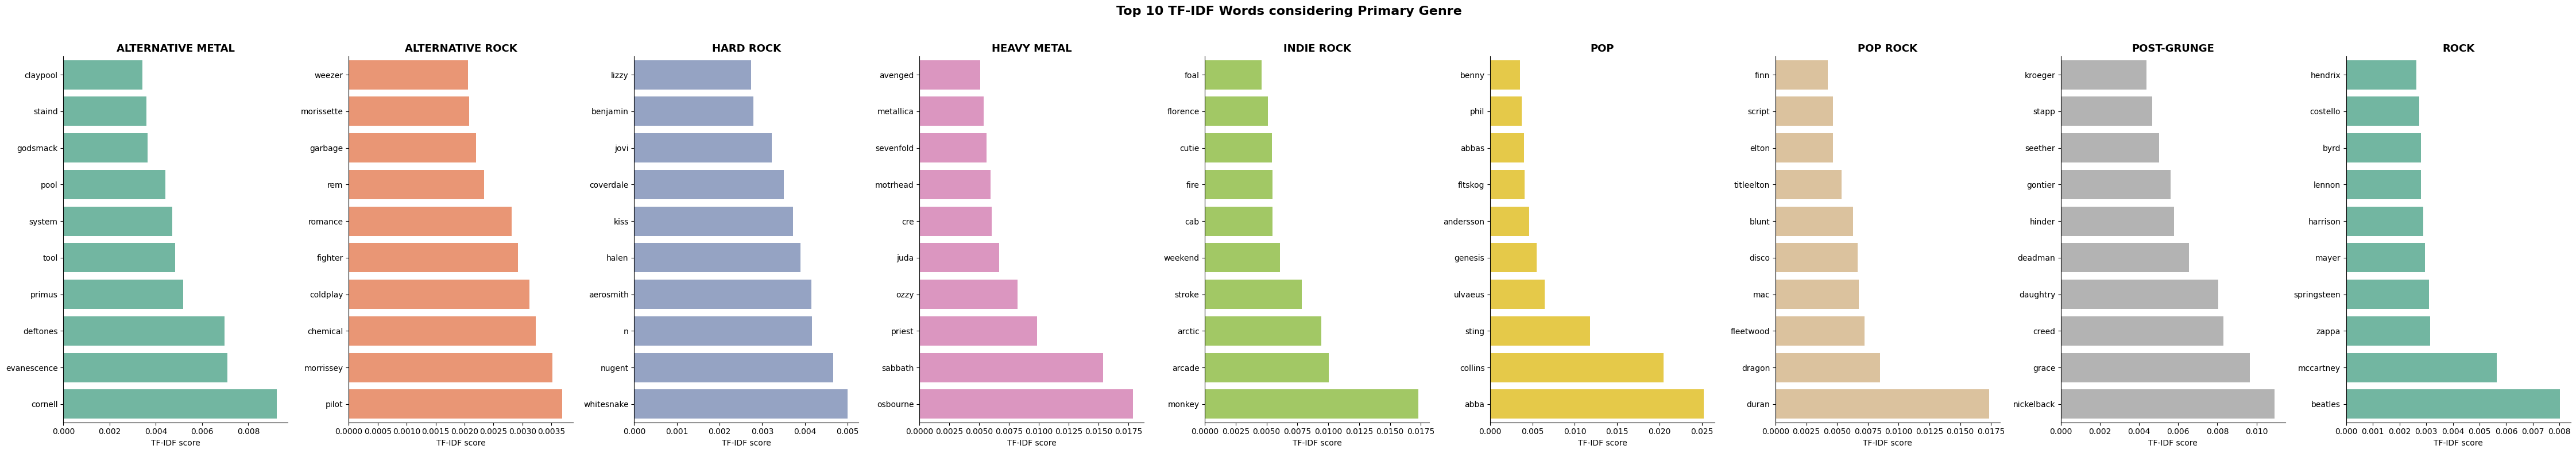

In [86]:
plot_tfidf_bars(tfidf_primary, label_type="Primary Genre", save_path="plots/tfidf_primary.png")

Saved TF-IDF bar plot to: plots/tfidf_random.png


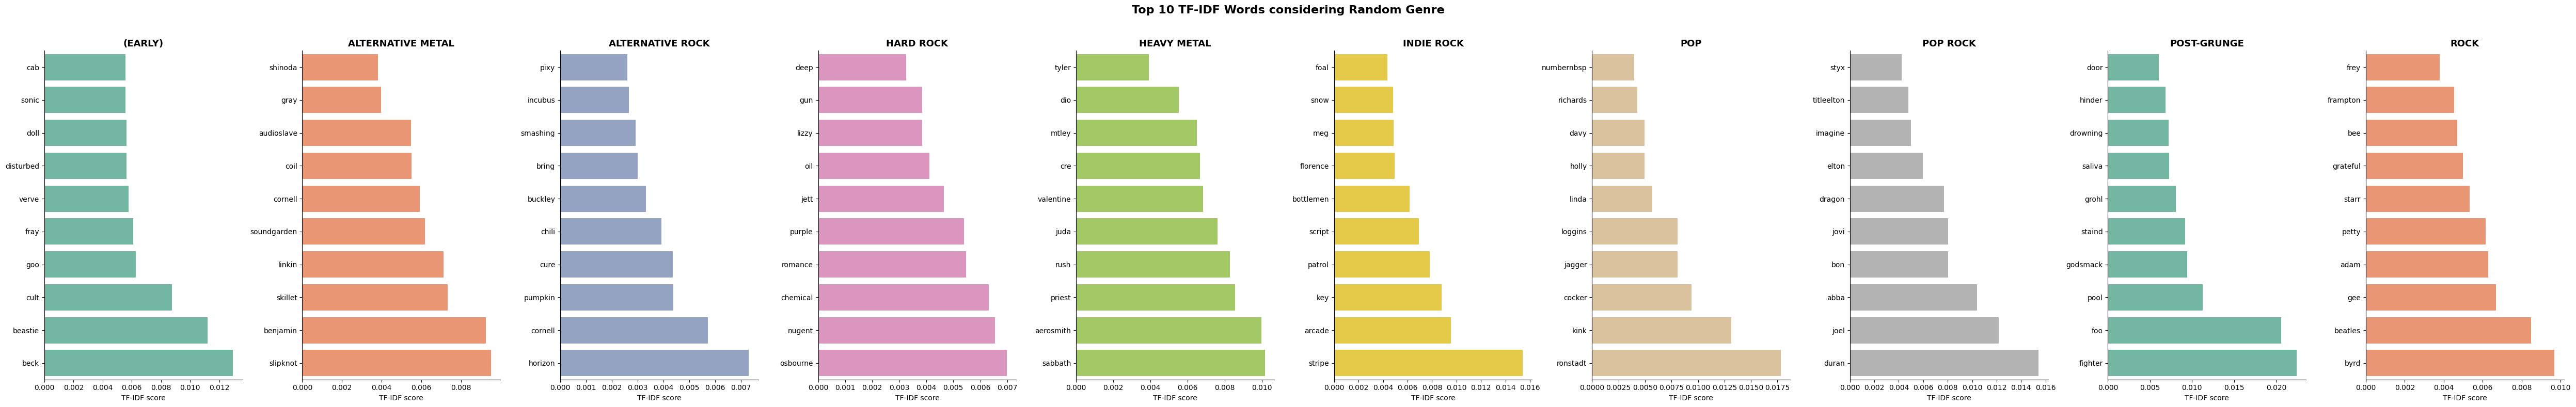

In [83]:
plot_tfidf_bars(tfidf_random, label_type="Random Genre", save_path="plots/tfidf_random.png")

Saved TF-IDF bar plot to: plots/tfidf_louvain.png


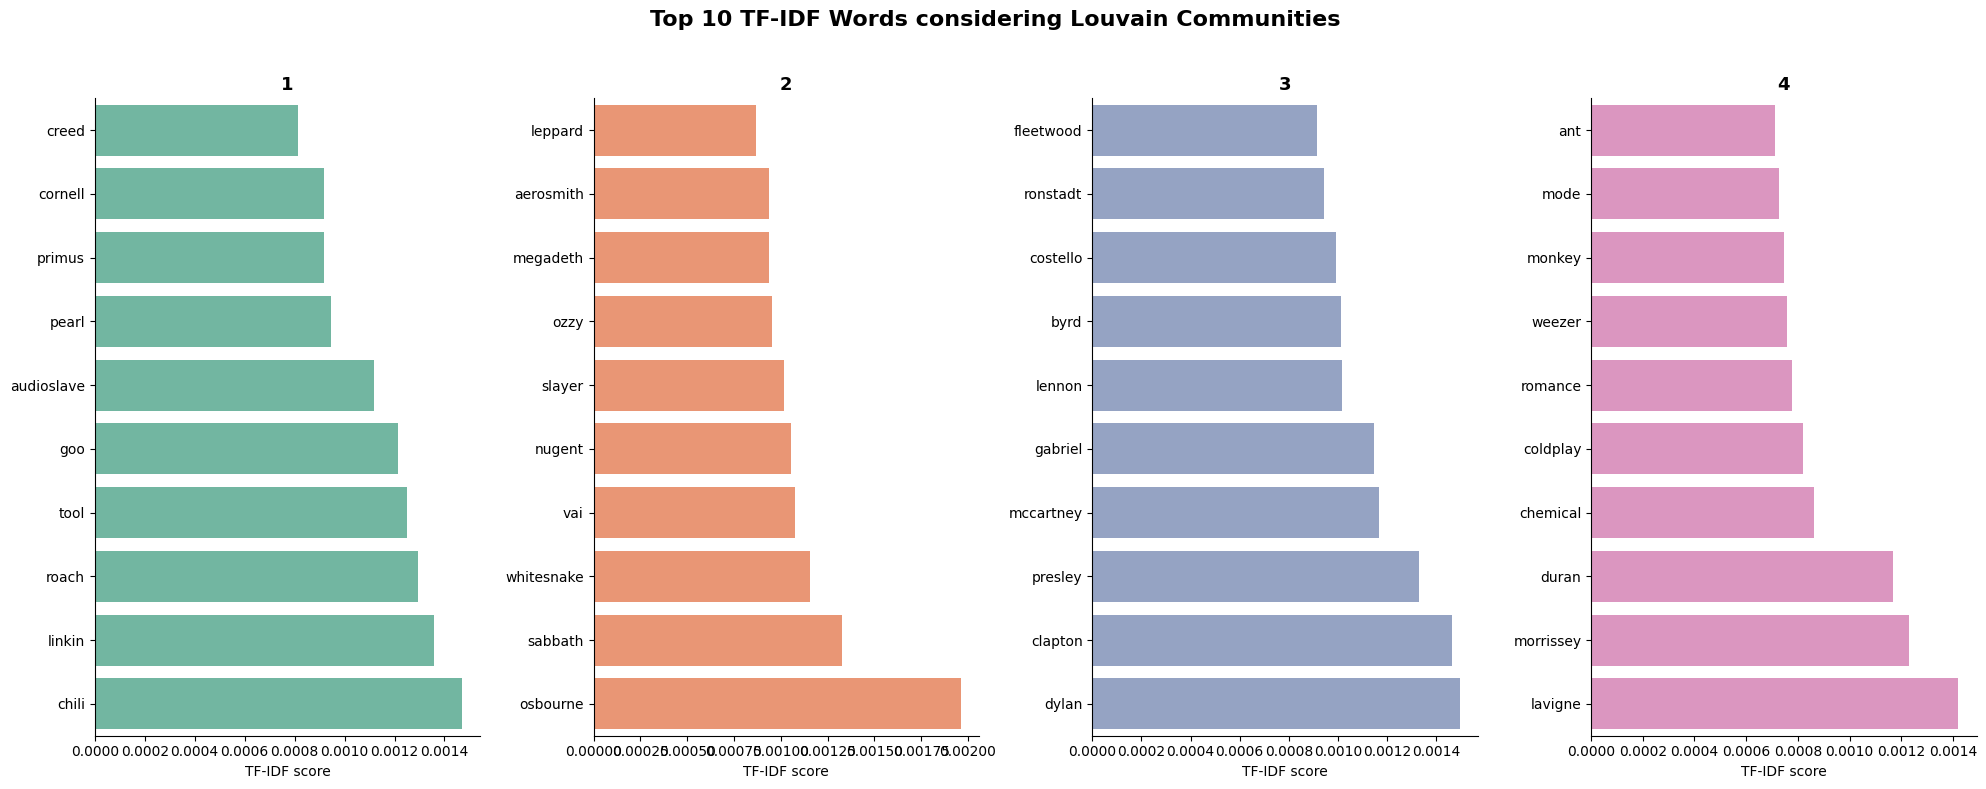

In [ ]:
plot_tfidf_bars(tfidf_louvain, label_type="Louvain Communities", save_path="plots/tfidf_louvain.png")

**[INSERT COMMENT ON EACH OF THE PICTURES]**

3) Use the matrix D
 (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.
 

In [ ]:
def create_wordclouds(group_tfidf, out_folder, label_type="genre", max_words=100):
    """
    Create and save word clouds for each community/group based on TF-IDF scores.

    Parameters
    group_tfidf : dict
        Dict from compute_tfidf(): {group_name: {word: tfidf_value}}
    out_folder : str or Path
        Folder where the PNG files will be saved
    label_type : str
        Label type to show in titles (e.g. 'primary genre', 'louvain community')
    max_words : int
        Maximum number of words in each word cloud
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True)

    for group_name, tfidf_scores in group_tfidf.items():
        if not tfidf_scores:
            continue

        # Normalize values (optional but helps visual scaling)
        max_val = max(tfidf_scores.values())
        freqs = {word: score / max_val for word, score in tfidf_scores.items()}

        # Create world-cloud 
        wc = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            max_words=max_words,
            colormap="viridis",
            random_state=42
        ).generate_from_frequencies(freqs)

        # Save figure
        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for '{group_name}'", fontsize=14)
        out_path = out_folder / f"{group_name}_wordcloud.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()

        print(f"Saved word cloud: {out_path}")


In [33]:
create_wordclouds(tfidf_primary, "wordclouds_primary", label_type="Primary Genre")

Saved word cloud: wordclouds_primary\primary_alternative metal_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_alternative rock_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_hard rock_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_heavy metal_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_indie rock_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_pop rock_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_pop_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_post-grunge_TF_wordcloud.png
Saved word cloud: wordclouds_primary\primary_rock_TF_wordcloud.png


In [ ]:
create_wordclouds(tfidf_random, "wordclouds_random", label_type="Random Genre")

Saved word cloud: wordclouds_random\random_(early)_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_alternative metal_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_alternative rock_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_hard rock_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_heavy metal_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_indie rock_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_pop rock_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_pop_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_post-grunge_TF_wordcloud.png
Saved word cloud: wordclouds_random\random_rock_TF_wordcloud.png


In [ ]:
create_wordclouds(tfidf_louvain, "wordclouds_louvain", label_type="Louvain Community")

Saved word cloud: wordclouds_louvain\louvain_louvain_1_TF_wordcloud.png
Saved word cloud: wordclouds_louvain\louvain_louvain_2_TF_wordcloud.png
Saved word cloud: wordclouds_louvain\louvain_louvain_3_TF_wordcloud.png
Saved word cloud: wordclouds_louvain\louvain_louvain_4_TF_wordcloud.png


**[INSERT COMMENT ABOUT THE RELATIONSHIP OF THE WORDCLOUDS OF THE COMMUNITIES AND GENDERS THAT ARE MORE RELATED]**

**Does it make sense to consider the diferent divisions of genres I considered here? Or should I just do the calculations with all the genres of each artist like in the D matrix of the second part?**

I think I will include the all genres of each node metric to compare the TF-IDF results with the ones found for the other metrics considered (primary and random). 
Then I will use that to build the world clouds to better compare with the D matrix of part 2. What do you think?